In [1]:
import numpy as np

# original_distribution은 전체 합이 1인 1D 넘파이 배열이다.
# temperature는 출력 분포의 엔트로피의 양을 결정한다.
def reweight_distribution(original_distribution, temperature=0.5):
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    return distribution / np.sum(distribution)  # 원본 분포의 가중치를 변경하며 반환한다. 이 분포의 합은 1이 아닐 수 있으므로 새로운 분포의 합으로 나눈다.

In [2]:
!wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!rm -f aclImdb_v1.tar.gz

--2024-02-19 17:54:34--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
ai.stanford.edu (ai.stanford.edu) 해석 중... 171.64.68.10
다음으로 연결 중: ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 84125825 (80M) [application/x-gzip]
저장 위치: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  6.22MB/s    / 13s      

2024-02-19 17:54:50 (6.20 MB/s) - ‘aclImdb_v1.tar.gz’ 저장함 [84125825/84125825]



In [3]:
import tensorflow as tf
from tensorflow import keras

dataset = keras.utils.text_dataset_from_directory(
    directory="aclImdb", label_mode=None, batch_size=256,
)
dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 105006 files belonging to 1 classes.


2024-02-19 17:56:53.543576: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 17:56:53.572636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-19 17:56:53.572776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
from tensorflow.keras.layers import TextVectorization

sequence_length = 100
vocab_size = 15000
text_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    # 길이가 100인 입력과 타깃을 사용한다(타깃은 한 스텝 차이가 나기 때문에 모델은 99개의 단어 시퀀스를 보게 된다).
    output_sequence_length=sequence_length,
)
text_vectorization.adapt(dataset)

In [8]:
def prepare_Im_dataset(text_batch):
    vectorized_sequences = text_vectorization(text_batch)
    x = vectorized_sequences[:, :-1]    # 마지막 단어를 제외한 입력을 만든다.
    y = vectorized_sequences[:, 1:]     # 첫 단어를 제외한 타깃을 만든다.
    return x, y

Im_dataset = dataset.map(prepare_Im_dataset, num_parallel_calls=8)

In [10]:
from tensorflow.keras import layers

In [11]:
class PositionalEmbedding(layers.Layer):
    # 위치 임베딩의 단점은 시퀀스 길이를 미리 알아야 한다는 것이다.
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        # 토큰 인덱스를 위한 Embedding 층을 준비한다.
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim,
        )
        # 토큰 위치를 위한 Embedding 층을 준비한다.
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim,
        )
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
    
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        # 두 임베딩 벡터를 더한다.
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)
    
    # 모델 저장을 위한 직렬화를 구현한다.
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [12]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm_1 = layers.LayerNormalization(epsilon=1e-7)
        self.layernorm_2 = layers.LayerNormalization(epsilon=1e-7)
        self.layernorm_3 = layers.LayerNormalization(epsilon=1e-7)
        # 이 속성은 층이 입력 마스킹을 출력으로 전달하도록 만든다.
        # 케라스에서 마스킹을 사용하려면 명시적으로 설정을 해야 한다.
        # compute_mask() 메소드를 구현하지 않으면서 supports_masking 속성을 제공하지 않는 층에 마스킹을 전달하면 에러가 발생한다.
        self.supports_masking = True
        
    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")   # 절반은 1이고 나머지는 0인 (sequence_length, sequence_length) 크기의 행렬을 만든다.
        # 배치 축에 반복하여 (batch_size, sequence_length, sequence_length) 크기의 행렬을 얻는다.
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([
            tf.expand_dims(batch_size, -1),
            tf.constant([1, 1], dtype=tf.int32)
        ], axis=0)
        return tf.tile(mask, mult)
    
    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)        # 코잘 마스킹을 추출한다.
        # 타깃 시퀀스에 있는 패딩 위치를 나타내는 입력 마스킹을 준비한다.
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)    # 두 마스킹을 합친다.
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask,
        )
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)
        
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

In [18]:
from tensorflow.keras import layers
embed_dim = 256
latent_dim = 2048
num_heads = 2

inputs = keras.Input(shape=(None, ), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
)

In [19]:
import numpy as np

tokens_index = dict(enumerate(text_vectorization.get_vocabulary()))

def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

class TextGenerator(keras.callbacks.Callback):
    def __init__(self,
                 prompt,                # 텍스트 생성을 위한 시작 문장
                 generate_length,       # 생성할 단어 개수
                 model_input_length,
                 temperatures=(1., ),   # 샘플링에 사용할 온도 범위
                 print_freq=1):
        self.prompt = prompt
        self.generate_length = generate_length
        self.model_input_length = model_input_length
        self.temperatures = temperatures
        self.print_freq = print_freq
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_freq != 0:
            return
        for temperature in self.temperatures:
            print("== Generating with temperature", temperature)
            sentence = self.prompt      # 시작 단어에서부터 텍스트를 생성한다.
            for i in range(self.generate_length):
                # 현재 시퀀스를 모델에 주입한다.
                tokenized_sentence = text_vectorization([sentence])
                predictions = self.model(tokenized_sentence)
                # 마지막 타임스텝의 예측을 추출하여 다음 단어를 샘플링한다.
                next_token = sample_next(predictions[0, i, :])
                sampled_token = tokens_index[next_token]
                # 새로운 단어를 현재 시퀀스에 추가하고 반복한다.
                sentence += " " + sampled_token
            print(sentence)

prompt = "This movie"
text_gen_callback = TextGenerator(
    prompt,
    generate_length=50,
    model_input_length=sequence_length,
    temperatures=(0.2, 0.5, 0.7, 1., 1.5)
)

In [20]:
model.fit(Im_dataset, epochs=10, callbacks=[text_gen_callback])

Epoch 1/10


411/411 [==============================] - ETA: 0s - loss: 5.9050== Generating with temperature 0.2
This movie is was a shot mum as [UNK] when is i it remember mattered movie a it good i in thought a it very for [UNK] a bottom couple not of really [UNK] does a not [UNK] know [UNK] why acting they and beat seriously its [UNK] like ray us [UNK]
== Generating with temperature 0.5
This movie great along story her of or the great death suffice of to making a the vent last in scene good the moments psychological thats a whod [UNK] to the watch you in look eerie at presenting love farmhouse instead for of most mannerisms chavez as and [UNK] rather but widely
== Generating with temperature 0.7
This movie is tries erotic to for life its account more of scary times and its turgid here this during was the fought movie of to this conception film of that the is one mainly around we depth come as to close watch to it indeed is it the so great whereas
== Generating with temperature 1.0
This movie and

440742/440742 [==============================] - 1s 3us/step


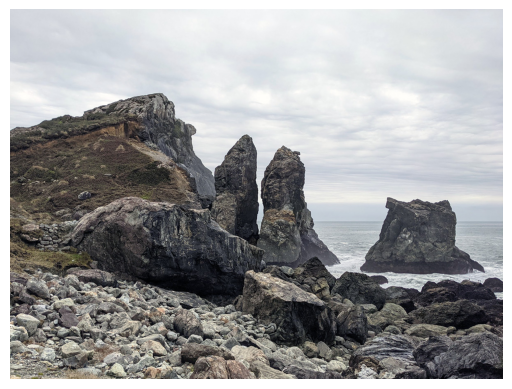

In [21]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file(
    "coast.jpg",
    origin="https://img-datasets.s3.amazonaws.com/coast.jpg"
)

plt.axis("off")
plt.imshow(keras.utils.load_img(base_image_path))

In [22]:
from tensorflow.keras.applications import inception_v3

model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87910968/87910968 [==============================] - 3s 0us/step


In [46]:
layer_settings = {
    "mixed1": 1.0,
    "mixed2": 1.5,
    "mixed3": 2.0,
    "mixed4": 2.5,
}

outputs_dict = dict([
    (layer.name, layer.output)
    for layer in [
        model.get_layer(name)
        for name in layer_settings.keys()
    ]
])

feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [47]:
def compute_loss(input_image):
    features = feature_extractor(input_image)   # 활성화를 추출한다.
    loss = tf.zeros(shape=())                   # 손실을 0으로 초기화한다.
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # 경계 부근의 인공적인 패턴을 피하기 위해 테두리가 아닌 픽셀만 손실에 추가한다.
        loss += (coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :])))
    return loss

In [48]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    # 현재 이미지에 대한 딥드림 손실의 그레이디언트를 계산한다.
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)     # 그레이디언트를 정규화한다.
    image += (learning_rate * grads)
    return loss, image

# 주어진 이미지 스케일(옥타브)에 대한 경사 상승법을 수행한다.
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        # 손실이 임계 값을 넘으면 중지한다. 과도하게 최적화하면 원치 않는 이미지를 얻을 수 있다.
        if max_loss is not None and loss > max_loss:
            break
        print(f"... 스텝 {i}에서 손실 값: {loss:.2f}")
    return image

In [49]:
# parameters
step = 20.          # 경사 상승법 단계 크기
num_octave = 3      # 경사 상승법을 실행할 스케일 횟수
octave_scale = 1.4  # 연속적인 스케일 사이의 크기 비율
iterations = 30     # 스케일 단계마다 수행할 경사 상승법 단계 횟수
max_loss = 100.      # 이보다 손실이 커지면 현재 스케일에서 경사 상승법 과정을 중지한다.

In [50]:
import numpy as np

# 이미지를 로드하고 크기를 바꾸어 적절한 배열로 변환하는 유틸리티 함수
def preprocess_image(image_path):
    img = keras.utils.load_img(image_path)
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

# 넘파이 배열을 이미지로 변환하는 유틸리티 함수
def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    # InceptionV3 전처리 복원하기
    img += 1.0
    img *= 127.5
    img = np.clip(img, 0, 255).astype("uint8")  # uint8로 바꾸고 [0, 255] 범위로 클리핑한다.
    return img

In [51]:
original_img = preprocess_image("me.jpg")
original_shape = original_img.shape[1:3]

# 여러 옥타브에서 이미지 크기를 계산한다.
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)                 # 이미지를 하드 카피한다.
for i, shape in enumerate(successive_shapes):   # 여러 옥타브에 대해 반복한다.
    print(f"{shape} 크기의 {i}번째 옥타브 처리")
    img = tf.image.resize(img, shape)           # 딥드림 이미지의 스케일을 높인다.
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss,
    )
    # 작은 버전의 원본 이미지의 스케일을 높인다. 픽셀 경계가 보일 것이다.
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    # 이 크기에 해당하는 고해상도 버전의 원본 이미지를 계산한다.
    same_size_original = tf.image.resize(original_img, shape)
    # 두 이미지의 차이가 스케일을 높였을 때 손실된 디테일이다.
    lost_detail = same_size_original - upscaled_shrunk_original_img
    # 손실된 디테일을 딥드림 이미지에 다시 주입한다.
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.utils.save_img("me.png", deprocess_image(img.numpy()))

(688, 551) 크기의 0번째 옥타브 처리
... 스텝 0에서 손실 값: 2.93
... 스텝 1에서 손실 값: 3.53
... 스텝 2에서 손실 값: 4.46
... 스텝 3에서 손실 값: 5.62
... 스텝 4에서 손실 값: 6.86
... 스텝 5에서 손실 값: 8.11
... 스텝 6에서 손실 값: 9.35
... 스텝 7에서 손실 값: 10.57
... 스텝 8에서 손실 값: 11.77
... 스텝 9에서 손실 값: 12.91
... 스텝 10에서 손실 값: 14.05
... 스텝 11에서 손실 값: 15.17
... 스텝 12에서 손실 값: 16.22
... 스텝 13에서 손실 값: 17.31
... 스텝 14에서 손실 값: 18.27
... 스텝 15에서 손실 값: 19.32
... 스텝 16에서 손실 값: 20.26
... 스텝 17에서 손실 값: 21.17
... 스텝 18에서 손실 값: 22.09
... 스텝 19에서 손실 값: 23.01
... 스텝 20에서 손실 값: 23.88
... 스텝 21에서 손실 값: 24.73
... 스텝 22에서 손실 값: 25.58
... 스텝 23에서 손실 값: 26.33
... 스텝 24에서 손실 값: 27.16
... 스텝 25에서 손실 값: 27.95
... 스텝 26에서 손실 값: 28.72
... 스텝 27에서 손실 값: 29.48
... 스텝 28에서 손실 값: 30.22
... 스텝 29에서 손실 값: 30.94
(964, 771) 크기의 1번째 옥타브 처리
... 스텝 0에서 손실 값: 6.26
... 스텝 1에서 손실 값: 8.83
... 스텝 2에서 손실 값: 10.97
... 스텝 3에서 손실 값: 12.78
... 스텝 4에서 손실 값: 14.41
... 스텝 5에서 손실 값: 15.87
... 스텝 6에서 손실 값: 17.26
... 스텝 7에서 손실 값: 18.59
... 스텝 8에서 손실 값: 19.93
... 스텝 9에서 손실 값: 21.24
... 스텝 10에서 손실 값:

In [33]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

In [1]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg",
    origin="https://img-datasets.s3.amazonaws.com/sf.jpg",
)
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg",
    origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg",
)

original_width, original_height = keras.utils.load_img(base_image_path).size
img_height=400
img_width=round(original_width * img_height / original_height)

943128/943128 [==============================] - 6s 6us/step


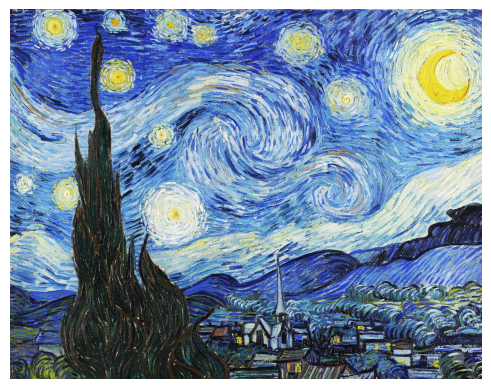

In [5]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(keras.utils.load_img(style_reference_image_path))

In [6]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    # ImageNet의 평균 픽셀 값을 더한다. 이는 vgg19.preprocess_input 함수에서 수행한 변환을 복원한다.
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 이미지를 BGR에서 RGB로 변경한다. 이는 vgg19.preprocess_input 함수에서 수행한 변환을 복원한다.
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img
    

In [7]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
# 이 모델은 모든 타깃 층의 활성화 값을 하나의 딕셔너리로 반환한다.
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

2024-02-20 18:01:53.530607: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


80134624/80134624 [==============================] - 28s 0us/step


In [8]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [9]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [10]:
def total_variation_loss(x):
    a = tf.square(
        x[:, :img_height-1, :img_width-1, :] - x[:, 1:, :img_width-1, :]
    )
    b = tf.square(
        x[:, :img_height-1, :img_width-1, :] - x[:, :img_height-1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [11]:
style_layer_names = [                   # 스타일 손실에 사용할 층
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"     # 콘텐츠 손실에 사용할 층
total_variation_weight = 1e-6           # 총 변이 손실의 기여 가중치
style_weight = 1e-6                     # 스타일 손실의 기여 가중치
content_weight = 2.5e-8                 # 콘텐츠 손실의 기여 가중치

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image],
        axis=0,
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(
        base_image_features, combination_features,
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
            style_reference_features, combination_features,
        )
        loss += (style_weight / len(style_layer_names)) * style_loss_value
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [13]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96,
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
# 훈련하는 동안 합성된 이미지를 업데이트하기 때문에 Variable에 저장한다.
combination_image = tf.Variable(preprocess_image(base_image_path))
iterations = 4000

for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image,
    )
    # 스타일 트랜스퍼 손실이 감소되는 방향으로 합성 이미지를 업데이트한다.
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"{i}번째 반복: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"style_transfer/combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

100번째 반복: loss=8137.47
200번째 반복: loss=6651.92


KeyboardInterrupt: 